In [13]:
%%capture
%run preprocessing.ipynb

# METHODOLOGIE DU CLUSTERING ET DES EMBEDDINGS

En fonction du type d'embeddings que nous allons utiliser, nous allons choisir une méthode de clustering adaptée.<br>
Passons en revue les différents types d'embeddings :
* **CountVectorizer** : Génère un BOW (fréquence de chaque mot présent dans le corpus au sein de chaque document). En fonction du nombre de dimensions obtenues, il sera peut-être nécessaire de réduire la dimensionnalité avant d'utiliser une méthode de clustering.
* **TfidfVectorizer** : Génère un BOW pondéré par l'inverse de la fréquence du mot dans le corpus. En fonction du nombre de dimensions obtenues, il sera peut-être nécessaire de réduire la dimensionnalité avant d'utiliser une méthode de clustering.

La démarche est de générer différents BOW et de tester l'ARI.<br>
Une première étape importante sur les BOW est de réduire la dimensionnalité pour éviter le fléau de la dimensionnalité.<br>
Afin de gagner du temps sur les calculs, nous allons créer nos corpus de texte dans un dictionnaire `corpus`:

In [33]:
def spacy_preprocessor(doc):
    return " ".join(
        [
            token.lemma_
            for token in trf(doc)
            if not token.is_stop and not token.like_num and token.is_alpha
        ]
    )

## TF-IDF CV

Nous allons créer deux corpus de documents :
* `corpus`: contient tous les documents textes sans preprocessing quelconque.
* `corpus_preprocessed`: contient tous les documents textes après preprocessing.

In [34]:
# Création des deux dictionnaires
corpus = dict()
corpus_preprocessed = dict()

# check if the corpus and corpus_preprocessed dictionaries has a pkl file in the current directory
if os.path.exists("corpus.pkl") and os.path.exists("corpus_preprocessed.pkl"):
    # Load the corpus and corpus_preprocessed dictionaries from the pkl files
    with open("corpus.pkl", "rb") as file:
        corpus = pickle.load(file)
    with open("corpus_preprocessed.pkl", "rb") as file:
        corpus_preprocessed = pickle.load(file)

# If not, create the dictionaries
else:
    # Itére sur options
    for option in tqdm(options):
        # Assigne la variable texte à la colonne option
        text = flipkart_filtered[option].dropna().str.lower()
        # Création d'une liste de textes
        corpus[option] = text.tolist()
        # Crée une liste de tokens pour chaque texte dans text
        corpus_preprocessed[option] = [
            " ".join(
                token.lemma_
                for token in doc
                if not token.is_stop and not token.like_num and token.is_alpha
            )
            for doc in trf.pipe(text)
        ]
    # Sauvegarde les dictionnaires dans des fichiers pkl
    with open("corpus.pkl", "wb") as file:
        pickle.dump(corpus, file)
    with open("corpus_preprocessed.pkl", "wb") as file:
        pickle.dump(corpus_preprocessed, file)


On peut regarder à présent si nous avons des pattern à haute fréquence dans les documents textes et de vérifier s'il s'agit de bruit:

In [35]:
# Assign the CountVectorizer instance to the vectorizer variable
cv = CountVectorizer(strip_accents="unicode")
cv_preprocessed = CountVectorizer(strip_accents="unicode")

In [36]:
# Assigne un dictionnaire qui contiendra les embeddings des textes
cv_embeddings = dict()
cv_preprocessed_embeddings = dict()

# Itère sur options
for option in tqdm(options):
    current_text = corpus[option]
    current_text_preprocessed = corpus_preprocessed[option]

    # Fit the vectorizer on the text column
    cv.fit(current_text)
    cv_preprocessed.fit(current_text_preprocessed)

    # Récupération du nom des features
    features = cv.get_feature_names_out()
    features_preprocessed = cv_preprocessed.get_feature_names_out()

    # Transform the text column
    X = cv.transform(current_text)
    X_preprocessed = cv_preprocessed.transform(current_text_preprocessed)

    # Création d'un BOW sous forme de dataframe qu'on affecte dans le dictionnaire
    cv_embeddings[option] = pd.DataFrame(X.toarray(), columns=features)
    cv_preprocessed_embeddings[option] = pd.DataFrame(
        X_preprocessed.toarray(), columns=features_preprocessed
    )

100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


On veut regarder les mots les plus fréquents avec le count vectorizer sur la séquence préprocessée et comparer avec la séquence brut(sans ponctuation).

In [37]:
# On veut récupérer la fréquence relative de chaque mot dans chaque colonne
for option in options:
    cv_embeddings[f"{option}_freq"] = cv_embeddings[option].div(
        cv_embeddings[option].sum(axis=1), axis=0
    )
    cv_preprocessed_embeddings[f"{option}_freq"] = cv_preprocessed_embeddings[
        option
    ].div(cv_preprocessed_embeddings[option].sum(axis=1), axis=0)

Regardons le top 10 des mots les fréquents sur le texte non nettoyé :

In [38]:
for option in options:
    print(f"Top 10 words in {option} column:")
    print(cv_embeddings[f"{option}_freq"].sum().sort_values(ascending=False).head(10))
    print()

Top 10 words in product_name column:
for          21.679211
watch        21.508020
set          19.376070
analog       18.288997
cm           15.751661
showpiece    14.928320
baby         14.774614
combo        13.674623
ceramic      13.387908
mug          13.137908
dtype: float64

Top 10 words in description column:
only        26.911401
for         24.045444
rs          21.939549
at          20.255739
on          19.841916
free        18.607854
products    18.563147
buy         18.219676
delivery    18.197298
shipping    18.189398
dtype: float64

Top 10 words in text column:
for         23.607774
only        22.380297
rs          18.403008
at          16.752656
on          16.641672
of          16.598850
free        15.456056
products    15.382443
buy         15.098986
delivery    15.025199
dtype: float64



Regardons enfin la fréquence avec le texte prétraitée :

In [39]:
for option in options:
    print(f"Top 10 words in {option} column:")
    print(
        cv_preprocessed_embeddings[f"{option}_freq"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )
    print()

Top 10 words in product_name column:
watch        31.661508
analog       26.623016
set          21.573773
cm           19.642940
showpiece    18.422305
ceramic      16.001923
mug          15.751923
baby         15.582576
man          15.402381
combo        15.085173
dtype: float64

Top 10 words in description column:
product        31.074907
free           29.161604
delivery       28.533028
genuine        28.520474
cash           28.520474
shipping       28.520474
buy            28.509650
day            22.814880
replacement    22.232803
guarantee      21.673429
dtype: float64

Top 10 words in text column:
product        24.969959
free           23.208835
buy            22.636954
delivery       22.565651
cash           22.553392
genuine        22.553392
shipping       22.553392
day            18.795756
replacement    18.317929
guarantee      17.688783
dtype: float64



On constate que les mots les plus courants sont des mots relativement communs.<br>
Concernant les stop-words, je vais retirer toutes les possibles unités de mesure qui pourrait apparaître.<br>
Un Tf-Idf pourrait être intéressant pour réduire l'importance de ces mots.

In [40]:
# Add stop words to a list containing units of measurement
additional_stopwords = [
    "x",
    "xs",
    "xl",
    "l",
    "cm",
    "m",
    "ml",
    "cl",
    "g",
    "kg",
    "mg",
    "rs",
    "s",
]

On va également réaliser notre Tf-Idf sur le texte prétraité avec la liste aditionnelle de stop-words :

In [41]:
# Création d'une instance de TfIdfVectorizer
tfidf = TfidfVectorizer(
    stop_words=additional_stopwords,
    min_df=3,
    sublinear_tf=True,
    max_df=0.25,
    strip_accents="unicode",
)

In [42]:
# Assigne un dictionnaire qui contiendra les embeddings des textes
tfidf_preprocessed_embeddings = dict()

# Itère sur options
for option in tqdm(options):
    current_text_preprocessed = corpus_preprocessed[option]

    # Fit the vectorizer on the text column
    tfidf.fit(current_text_preprocessed)

    # Récupération du nom des features
    features = tfidf.get_feature_names_out()

    # Transform the text column
    X = tfidf.transform(current_text_preprocessed)

    # Création d'un BOW sous forme de dataframe qu'on affecte dans le dictionnaire
    tfidf_preprocessed_embeddings[option] = pd.DataFrame(X.toarray(), columns=features)

100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


In [43]:
for option in options:
    print(f"Top 10 words in {option} column:")
    print(
        tfidf_preprocessed_embeddings[option]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )
    print()

Top 10 words in product_name column:
watch        56.308677
showpiece    51.046545
analog       50.838607
set          40.797983
man          35.779430
baby         31.333645
ceramic      31.122837
mug          30.802121
combo        30.270798
boy          28.830856
dtype: float64

Top 10 words in description column:
watch        45.270519
analog       39.768640
set          36.855275
good         36.493550
showpiece    34.842029
combo        28.645484
india        28.340507
man          27.887686
great        26.140980
discount     25.507371
dtype: float64

Top 10 words in text column:
watch        47.750887
analog       42.351767
set          37.083251
showpiece    36.949029
good         30.702691
man          29.403136
combo        28.906902
india        24.733378
cotton       24.258996
baby         22.955733
dtype: float64



In [44]:
# Import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import logging

logging.disable(logging.WARNING)  # disable WARNING, INFO and DEBUG logging everywhere

In [45]:
l_cat = list(flipkart_filtered["category_0"].str.strip().unique())
y_cat_num = [
    (1 - l_cat.index(flipkart_filtered.loc[i, "category_0"].strip()))
    for i in range(len(flipkart_filtered))
]

In [46]:
l_cat

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [47]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(X, l_cat=l_cat, y_cat_num=y_cat_num):
    time1 = time.time()
    num_labels = len(l_cat)
    y_cat_ser = pd.Series(y_cat_num).align(X, join="right", axis=0)[0]
    # Détermination des clusters à partir des données avant Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X)
    tsne = manifold.TSNE(
        n_components=2,
        perplexity=30,
        max_iter=2000,
        init="random",
        learning_rate=200,
        random_state=42,
    )
    X_tsne = tsne.fit_transform(X)

    ARI = np.round(metrics.adjusted_rand_score(y_cat_ser, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_, y_cat_ser

In [48]:
params = dict()
params[0] = {"stop_words": additional_stopwords, "strip_accents": "unicode"}
params[1] = {
    "stop_words": additional_stopwords,
    "min_df": 3,
    "sublinear_tf": True,
    "max_df": 0.25,
    "strip_accents": "unicode",
}
params[2] = {
    "stop_words": additional_stopwords,
    "min_df": 3,
    "sublinear_tf": True,
    "max_df": 0.25,
    "max_features": 768,
    "strip_accents": "unicode",
}
params[3] = {
    "stop_words": additional_stopwords,
    "min_df": 3,
    "sublinear_tf": True,
    "max_df": 0.25,
    "max_features": 500,
    "strip_accents": "unicode",
}
params[4] = {
    "stop_words": additional_stopwords,
    "min_df": 3,
    "sublinear_tf": True,
    "max_df": 0.25,
    "max_features": 300,
    "strip_accents": "unicode",
}

In [49]:
# Assigne un dictionnaire qui contiendra les embeddings des textes
tfidf_preprocessed_embeddings = dict()

# Itère sur options
for option in tqdm(options):
    current_text_preprocessed = corpus_preprocessed[option]

    for key in params.keys():
        tfidf = TfidfVectorizer(**params[key])
        # Fit the vectorizer on the text column
        tfidf.fit(current_text_preprocessed)

        # Récupération du nom des features
        features = tfidf.get_feature_names_out()

        # Transform the text column
        X = tfidf.transform(current_text_preprocessed)

        # Création d'un BOW sous forme de dataframe qu'on affecte dans le dictionnaire
        tfidf_preprocessed_embeddings[option + str(key)] = pd.DataFrame(
            X.toarray(), columns=features
        )

100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


In [50]:
# import la fonction pour remettre à 0 l'output
from IPython.display import clear_output

In [53]:
scores = []
nb_features = []
for key in tqdm(tfidf_preprocessed_embeddings.keys()):
    bow = tfidf_preprocessed_embeddings[key]
    ARI, _, _, _ = ARI_fct(bow)
    scores.append(ARI)
    nb_features.append(bow.shape[1])
clear_output()
display(
    pd.DataFrame(
        {
            "params": tfidf_preprocessed_embeddings.keys(),
            "nb_features": nb_features,
            "ARI": scores,
        }
    ).sort_values(by="ARI", ascending=False)
)

,params,nb_features,ARI
14,text4,300,0.2986
1,product_name1,413,0.2840
2,product_name2,413,0.2840
3,product_name3,413,0.2840
9,description4,300,0.2792
4,product_name4,300,0.2763
8,description3,500,0.2729
6,description1,1321,0.2679
13,text3,500,0.2601
12,text2,768,0.2543


La configuration avec le corpus 'text' et les paramètres 4 obtient le meilleur score ARI.<br>
Regardons à présent la visualisation obtenue:

In [ ]:
ARI, X_tsne, labels = ARI_fct(tfidf_preprocessed_embeddings["text4"])


ARI :  0.2986 time :  14.0


In [ ]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI):
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=l_cat,
        loc="best",
        title="Categorie",
    )
    plt.title("Représentation des commentaires par catégories réelles")

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=set(labels),
        loc="best",
        title="Clusters",
    )
    plt.title("Représentation des commentaires par clusters")

    plt.show()
    print("ARI : ", ARI)

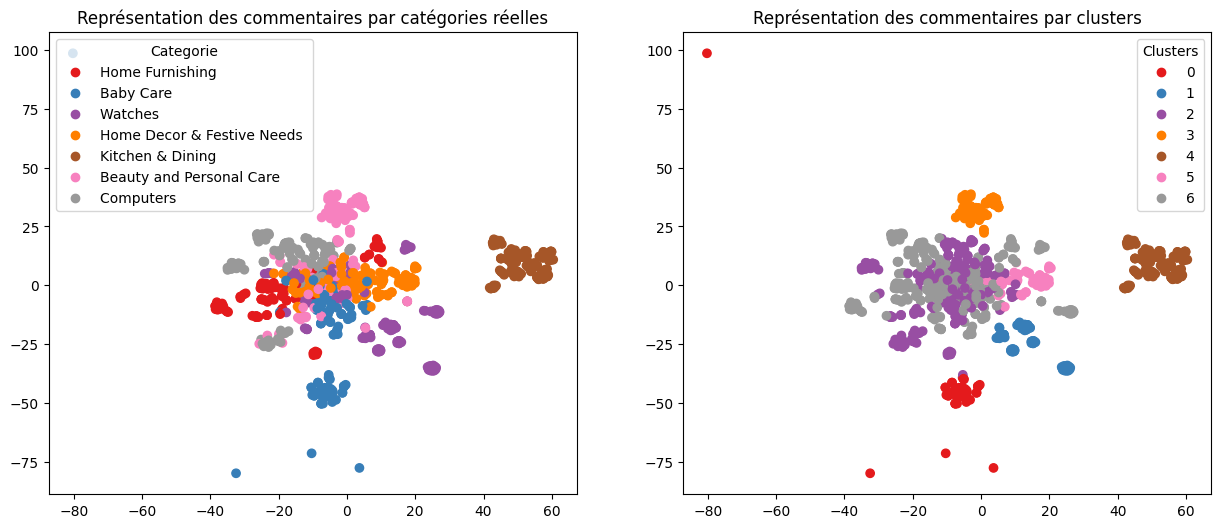

ARI :  0.2986


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [ ]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_umap_fct(features):
    time1 = time.time()
    num_labels = len(l_cat)
    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    # Calcul de l'embedding Umap pour un BOW TF-IDF
    umap = UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.3,
        metric="manhattan",
        random_state=42,
    )
    X_umap = umap.fit_transform(features)

    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_umap, cls.labels_

In [ ]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def UMAP_visu_fct(X_umap, y_cat_num, labels, ARI):
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], c=y_cat_num, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=l_cat,
        loc="best",
        title="Categorie",
    )
    plt.title("Représentation des commentaires par catégories réelles")

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=set(labels),
        loc="best",
        title="Clusters",
    )
    plt.title("Représentation des commentaires par clusters")

    plt.show()
    print("ARI : ", ARI)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ARI :  0.2986 time :  12.0


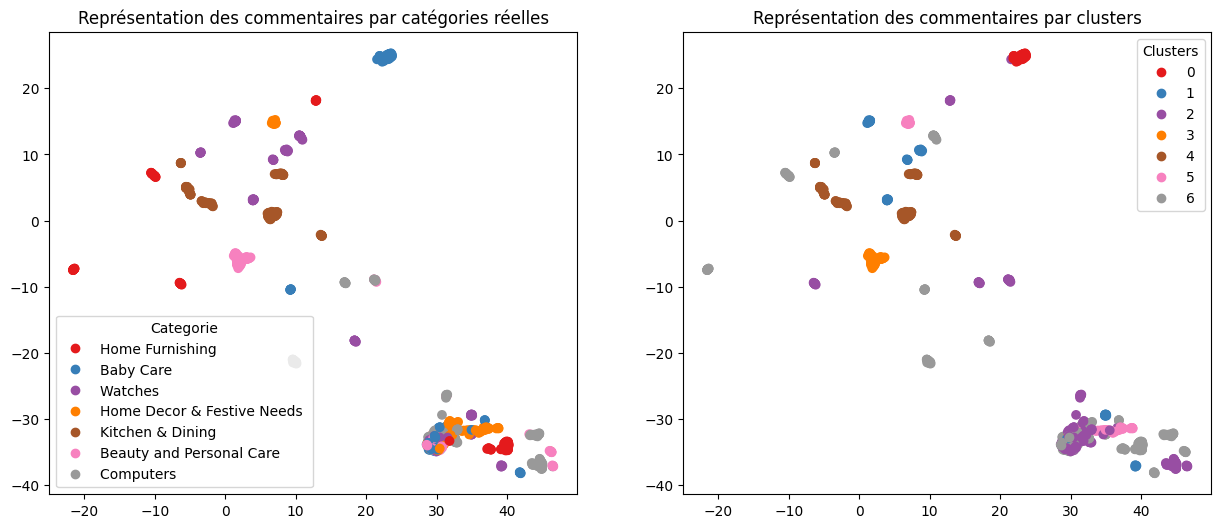

ARI :  0.2986


In [56]:
ARI, X_umap, labels = ARI_umap_fct(tfidf_preprocessed_embeddings["text4"])
UMAP_visu_fct(X_umap, y_cat_num, labels, ARI)

## WORD2VEC

Word2Vec est un réseau de neurones à 3 couches (entrée, hidden layer - compressed feature vector, sortie) pour projeter le mot dans un nouvel espace dont les dimensions sont caractérisées par le nombre de neurones dans la couche cachée.<br>
Plus le nombre de neurones de la couche cachée augmente et plus la dimensionnalité de l'espace de projection augmente. Chaque dimension est assimilable à une caractéristique sémantique du mot qui varie en fonction du contexte dans lequel il est utilisé.<br>
Le contexte est défini par la fenêtre de contexte qui est le nombre de mots avant et après le mot à prédire.


Pour définir le nombre de neurones de la couche cachée, il est possible de se baser sur la formule suivante :<br>
`hidden_layer_neurons = (2 * window_size + 1) * embedding_size`<br>
Dans notre cas, nous avons un window_size de 4 et un embedding_size de 100, donc nous allons choisir 900 neurones pour la couche cachée.

Nous allons entraîner notre modèle Word2Vec sur le corpus prétraité et regarder les mots les plus similaires à un mot donné :



Le modèle a été entraîné sur un corpus de texte très large et est capable de capturer les relations sémantiques entre les mots en utilisant la méthode SkipGram.<br>


La méthode d'entraînement sur notre corpus est intérressante à tester car elle permet de capturer les relations sémantiques entre les mots dans notre contexte particulier (description de produits).


Nous pouvons ensuite la comparer avec un modèle Word2Vec pré-entraîné sur un corpus de texte plus large et libre de droit (Wikipedia2vec)

### Utilisation du modèle `Word2vec/wikipedia2vec_frwiki_20180420_300d`

Je vais utiliser le modèle wikipedia2vec_frwiki_20180420_300d pour générer les embeddings des documents textes.<br>
Il a été entraîné avec les paramètres suivants : taille de fenêtre de 5, taille de vecteur de 300, 10 itérations et un sous-échantillonnage de 1e-5.<br>


Nous allons tester les performances de deux modèles Word2Vec pré-entraînés sur le corpus de wikipedia en anglais:
- 100d
- 300d

In [8]:
# Define repo and filename
repo_id = "Word2vec/wikipedia2vec_enwiki_20180420_100d"
filename = "enwiki_20180420_100d.txt"

# Load the wikipedia2vec model 100d
w2c_100 = KeyedVectors.load_word2vec_format(
    hf_hub_download(repo_id=repo_id, filename=filename)
)

In [11]:
# Compte le nombre de mots dans le vocab
vocab = list(w2c_100.key_to_index.keys())
print(f"Taille du vocabulaire du modèle {filename} : {len(vocab)} mots")

Taille du vocabulaire du modèle enwiki_20180420_100d.txt : 4530030 mots


In [9]:
w2c_nolm_300 = KeyedVectors.load_word2vec_format(
    hf_hub_download(repo_id="Word2vec/nlpl_82", filename="model.bin"),
    binary=True,
    unicode_errors="ignore",
)

model.bin:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

In [3]:
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download

model_name = "Word2vec/wikipedia2vec_enwiki_20180420_500d"
wikiw2c_bin = hf_hub_download(
    repo_id="http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_nolg_500d.pkl.bz2",
    filename="enwiki_20180420_nolg_500d.pkl.bz2",
)
wikiw2c_model = KeyedVectors.load_word2vec_format(wikiw2c_bin, binary=True)

HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': 'http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_nolg_500d.pkl.bz2'. Use `repo_type` argument if needed.

### Entraînement du modèle Word2Vec (CBOW / Skipgram) sur le corpus prétraité

In [57]:
from gensim.models import Word2Vec

In [58]:
params = dict()

In [59]:
params[0] = dict(
    min_count=1,
    window=5,
    vector_size=100,
    workers=4,
    sg=0,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    alpha=0.05,
    min_alpha=0.0001,
    seed=42,
)

In [60]:
params[1] = dict(
    min_count=1,
    window=7,
    vector_size=125,
    workers=4,
    sg=1,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    alpha=0.05,
    min_alpha=0.0001,
    seed=42,
)

In [61]:
params[2] = dict(
    min_count=1,
    window=10,
    vector_size=150,
    workers=4,
    sg=1,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    alpha=0.05,
    min_alpha=0.0001,
    seed=42,
)

In [62]:
params[3] = dict(
    min_count=3,
    window=10,
    vector_size=150,
    workers=4,
    sg=1,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    alpha=0.05,
    min_alpha=0.0001,
    seed=42,
)

In [113]:
word_embeddings = dict()
model = dict()

for option in options:
    # Texte tokenisé
    text = [doc.split() for doc in flipkart_filtered[option]]

    for i in range(4):
        current_key = f"{option}" + f" {str(i)}"
        # Entraînement du modèle Word2Vec avec gensim
        model[option] = Word2Vec(sentences=text, **params[i])

        # Accès aux embeddings
        word_embeddings[current_key] = model[option].wv

        # Affichage du nombre de mots dans le vocabulaire
        print(
            f"{option} - Nombre de mots dans le vocabulaire: {len(word_embeddings[current_key].key_to_index)}"
        )

product_name - Nombre de mots dans le vocabulaire: 2549
product_name - Nombre de mots dans le vocabulaire: 2549
product_name - Nombre de mots dans le vocabulaire: 2549
product_name - Nombre de mots dans le vocabulaire: 484
description - Nombre de mots dans le vocabulaire: 9587
description - Nombre de mots dans le vocabulaire: 9587
description - Nombre de mots dans le vocabulaire: 9587
description - Nombre de mots dans le vocabulaire: 3585
text - Nombre de mots dans le vocabulaire: 9587
text - Nombre de mots dans le vocabulaire: 9587
text - Nombre de mots dans le vocabulaire: 9587
text - Nombre de mots dans le vocabulaire: 4160


In [114]:
mean_embeddings = dict()
for key in word_embeddings.keys():
    # For each row in the flipkart_filtered text column, replace each word by its embedding and compute the mean of the embeddings
    mean_embeddings[key] = (
        flipkart_filtered[key.split()[0]]
        .apply(
            lambda x: np.mean(
                [
                    word_embeddings[key][word]
                    for word in x.split()
                    if word in word_embeddings[key]
                ],
                axis=0,
            )
        )
        .dropna()
    )

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [115]:
for key in mean_embeddings.keys():
    # Create a new DataFrame with the mean embeddings
    print(mean_embeddings[key].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0


In [116]:
mean_embeddings_df = dict()
for key in list(mean_embeddings.keys())[4:]:
    rng = mean_embeddings[key][0].shape
    mean_embeddings_df[key] = pd.DataFrame(
        mean_embeddings[key].tolist(), columns=[f"{key}_{i}" for i in range(rng[0])]
    )

In [127]:
for key in mean_embeddings_df.keys():
    ARI, _, _ = ARI_fct(mean_embeddings_df[key])

ARI :  0.2464 time :  7.0
ARI :  0.2464 time :  8.0
ARI :  0.2426 time :  9.0
ARI :  0.2499 time :  10.0
ARI :  0.2477 time :  9.0
ARI :  0.2922 time :  9.0
ARI :  0.2882 time :  9.0
ARI :  0.3003 time :  10.0


# GLOVE

In [128]:
# Loading the vectors from the glove text file
def load_glove_vectors(glove_file):
    with open(glove_file, "r", encoding="utf-8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    return words, word_to_vec_map


In [129]:
# Load the glove vectors 100d
words, word_to_vec_map = load_glove_vectors("./Glove/glove.6B.100d.txt")

In [130]:
# Print the number of words and the number of word vectors
print(f"Number of words: {len(words)}")
print(f"Number of word vectors: {len(word_to_vec_map)}")

Number of words: 400000
Number of word vectors: 400000


In [134]:
mean_glove_embeddings = dict()
for option in options:
    # For each row in the flipkart_filtered text column, replace each word by its embedding and compute the mean of the embeddings
    mean_glove_embeddings[option] = flipkart_filtered[option].apply(
        lambda x: np.mean(
            [word_to_vec_map[word] for word in x.split() if word in word_to_vec_map],
            axis=0,
        )
    )

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [139]:
glove = dict()
for option in options:
    glove[option] = pd.DataFrame(
        mean_glove_embeddings[option].dropna().tolist(),
        index=mean_glove_embeddings[option].dropna().index,
        columns=[f"glove_{i}" for i in range(100)],
    )

In [156]:
for option in options:
    print(f"GLOVE {option}: ")
    print("--------")
    ARI, X_tsne, labels = ARI_fct(glove[option])
    print("Non null values sample: ", len(labels))
    print()

GLOVE product_name: 
--------
ARI :  0.4627 time :  4.0
Non null values sample:  575

GLOVE description: 
--------
ARI :  0.2516 time :  8.0
Non null values sample:  1050

GLOVE text: 
--------
ARI :  0.2485 time :  10.0
Non null values sample:  1050



ARI :  0.4627 time :  5.0


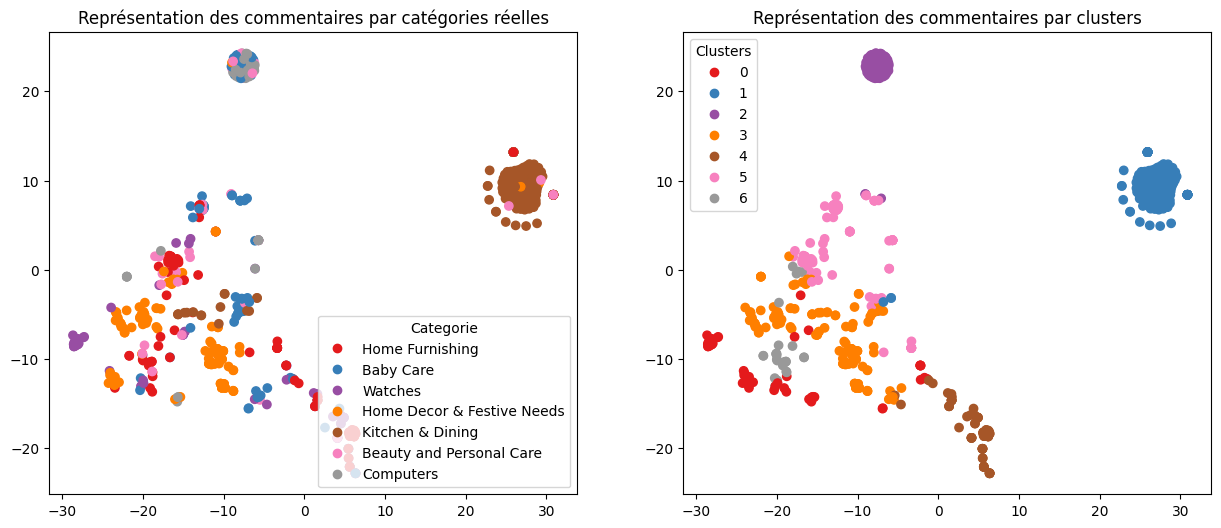

ARI :  0.4627


In [187]:
ARI, X_tsne, labels, y_cat_ser = ARI_fct(glove["product_name"])
TSNE_visu_fct(X_tsne, y_cat_ser.tolist(), labels, ARI)

Il existe une autre solution que de prendre la moyenne des embeddings.<br>
Nous allons utiliser une ponderation moyenne des word vectors d'un commentaire et ensuite effectué une PCA sur cet nouvel feature avant de l'envoyer au KMeans.<br>

In [174]:
# Make a weighted average of the word2vec embeddings
def weighted_average_word_vectors(words, word_to_vec_map):
    words = words.split()
    result = np.zeros(word_to_vec_map["hello"].shape)
    total_weight = 0
    for word in words:
        if word in word_to_vec_map:
            result += word_to_vec_map[word]
            total_weight += 1
    if total_weight == 0:
        return result
    return result / total_weight


In [194]:
weighted_embeddings = dict()
for option in options:
    weighted_embeddings[option] = flipkart_filtered[option].apply(
        lambda x: weighted_average_word_vectors(x, word_to_vec_map)
    )

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [195]:
# Create a DataFrame with the weighted embeddings
for option in options:
    print(f"WEIGHTED {option}: ")
    print("--------")
    ARI, X_tsne, labels = ARI_fct(pd.DataFrame(weighted_embeddings[option].tolist()))
    print("Non null values sample: ", len(labels))
    print()

WEIGHTED product_name: 
--------
ARI :  0.0212 time :  5.0


ValueError: too many values to unpack (expected 3)

# BERT

In [87]:
# import tensorflow_hub as hub

from tensorflow.keras.layers import *

# Bert
import os

os.environ["TF_KERAS"] = "1"

In [88]:
# install torch


In [89]:
# Import BERT
from transformers import BertTokenizer

In [90]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [91]:
# Tokenize the text column
tokenized = flipkart_filtered["text"].apply(
    lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="pt")
)

In [92]:
# Create a list of the tokenized tensors
tokenized_tensors = [tensor["input_ids"] for tensor in tokenized]

In [93]:
import tensorflow_hub as hub


In [94]:
# Load pretrained bert_en_uncased_L-12_H-768_A-12/3

model = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3")


In [95]:
# Load the bert_en_uncased_L-12_H-768_A-12/3 tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [96]:
text_exemple = "he loves working with data. It works like a charm at his work"

In [97]:
# Preprocess the text with AutoTokenizer
text_preprocessed = tokenizer(
    text_exemple, padding=True, truncation=True, return_tensors="tf"
)

In [98]:
type(text_preprocessed)

transformers.tokenization_utils_base.BatchEncoding

In [99]:
text_preprocessed.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [100]:
# Rename the keys with 'input_word_ids', 'input_mask' and 'input_type_ids'
text_preprocessed = {
    new_key: text_preprocessed[key]
    for key, new_key in zip(
        ["input_ids", "attention_mask", "token_type_ids"],
        ["input_word_ids", "input_mask", "input_type_ids"],
    )
}

In [101]:
model(text_preprocessed)

{'pooled_output': <tf.Tensor: shape=(1, 768), dtype=float32, numpy=
 array([[-0.8115362 , -0.43281254, -0.8407893 ,  0.6736862 ,  0.25930652,
         -0.15918832,  0.80316085,  0.395319  , -0.60529697, -0.9999533 ,
         -0.1440674 ,  0.74857247,  0.9808339 ,  0.43200144,  0.89965   ,
         -0.5881434 , -0.1741608 , -0.6108952 ,  0.26124337, -0.05552725,
          0.7695719 ,  0.9998587 ,  0.23705362,  0.3294831 ,  0.4991836 ,
          0.8945839 , -0.6643711 ,  0.9050723 ,  0.9432497 ,  0.75134546,
         -0.62738633,  0.29033208, -0.98952585, -0.22210148, -0.85258085,
         -0.98485917,  0.47806135, -0.5897473 , -0.16911384, -0.05109132,
         -0.84457606,  0.42141047,  0.99988556, -0.80680716,  0.45777485,
         -0.32805568, -0.99999774,  0.29927924, -0.834642  ,  0.59672356,
          0.6314274 ,  0.35424152,  0.21421577,  0.40874404,  0.4602158 ,
          0.14649184, -0.13518348,  0.07417732, -0.2371627 , -0.56410396,
         -0.61290586,  0.43653405, -0.528765

In [102]:
# Tokenize the text column
bert_tokens = flipkart_filtered["text"].apply(
    lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="tf")
)

In [103]:
bert_tokens[5].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [104]:
# Create a list of the tokenized tensors
bert_tensors = bert_tokens.tolist()

# Map the keys in each tensor to 'input_word_ids', 'input_mask' and 'input_type_ids'
bert_tensors = [
    {
        new_key: tensor[key]
        for key, new_key in zip(
            ["input_ids", "attention_mask", "token_type_ids"],
            ["input_word_ids", "input_mask", "input_type_ids"],
        )
    }
    for tensor in bert_tensors
]

In [105]:
bert_vectors = []

# for each tensor in the bert_tensors list, compute the embeddings with the BERT model
for tensor in bert_tensors:
    embeddings = model(tensor)
    bert_vectors.append(embeddings["pooled_output"].numpy().ravel())

In [106]:
# Unpack the list into a DataFrame
bert_df = pd.DataFrame(
    bert_vectors,
    index=flipkart_filtered.index,
    columns=[f"bert_{i}" for i in range(768)],
)

In [107]:
print("BERT: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(bert_df)

BERT: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.0665 time :  18.0


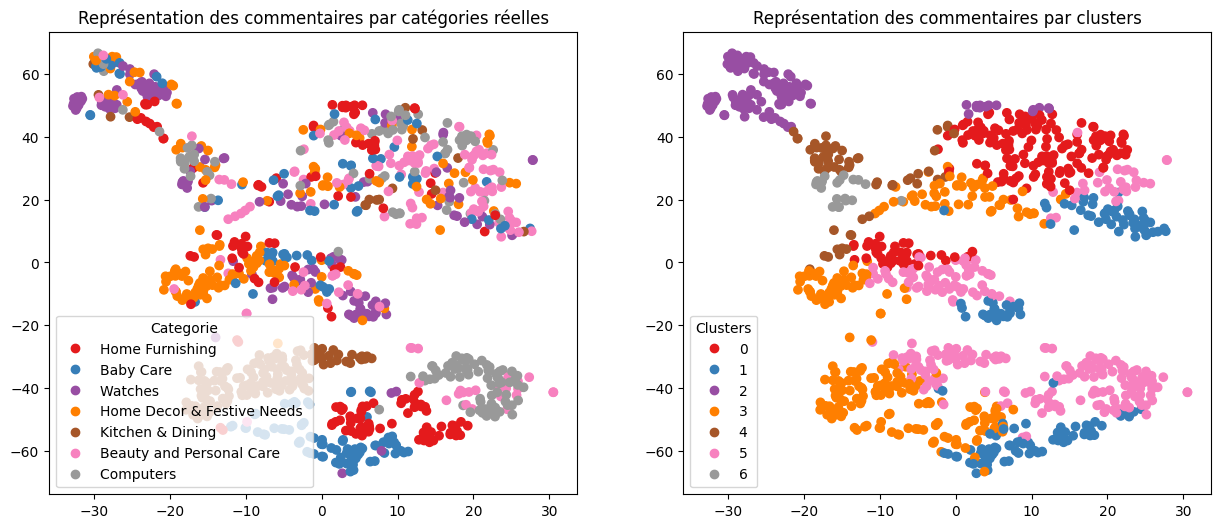

ARI :  0.0665


In [108]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [109]:
from transformers import RobertaTokenizer, TFRobertaModel

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = TFRobertaModel.from_pretrained("roberta-base")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors="tf")
output = model(encoded_input)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [110]:
# Tokenize the text column
roberta_tokens = flipkart_filtered["text"].apply(
    lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="tf")
)

In [111]:
roberta_output = roberta_tokens.apply(lambda x: model(x))

In [112]:
roberta_output[0].keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [113]:
# for each tensor in the bert_tensors list, compute the embeddings with the BERT model
roberta_vectors = []
for output in roberta_output:
    roberta_vectors.append(output["pooler_output"].numpy().ravel())

In [114]:
# Unpack the list into a DataFrame
roberta_df = pd.DataFrame(
    roberta_vectors,
    index=flipkart_filtered.index,
    columns=[f"bert_{i}" for i in range(768)],
)

In [115]:
print("ROBERTA: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(roberta_df)

ROBERTA: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.1345 time :  80.0


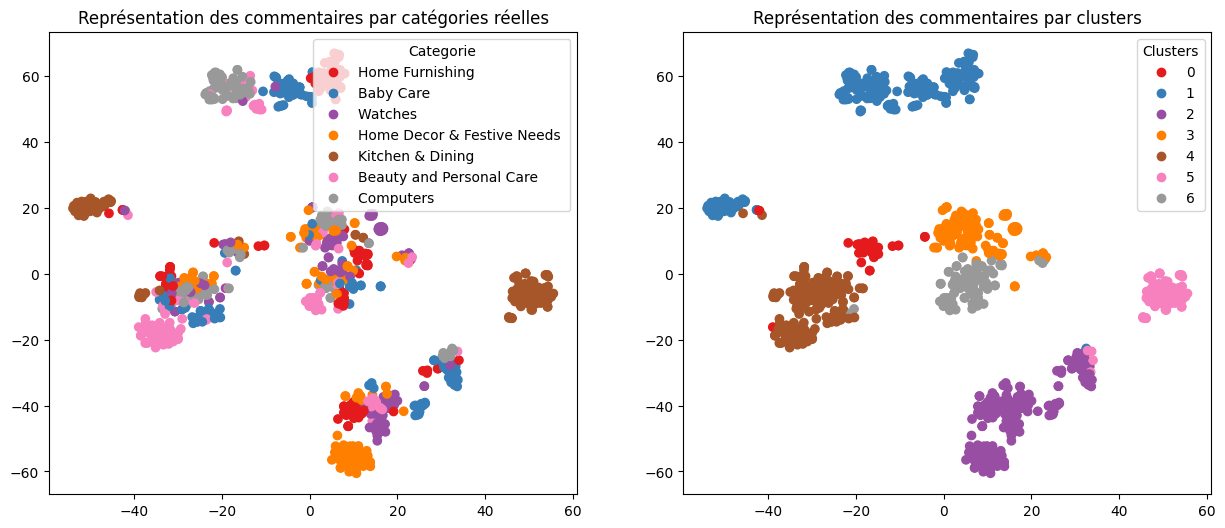

ARI :  0.1345


In [116]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE

Overview
The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. 

In [117]:
import tensorflow_hub as hub

In [118]:
# Load the Universal Sentence Encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [119]:
# Encode the text column with the Universal Sentence Encoder
use_embeddings = flipkart_filtered["text"].apply(lambda x: embed([x]).numpy().ravel())

In [120]:
# Unpack the list into a DataFrame
use_df = pd.DataFrame(
    use_embeddings.tolist(),
    index=flipkart_filtered.index,
    columns=[f"use_{i}" for i in range(512)],
)

In [121]:
print("USE: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(use_df)

USE: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.3503 time :  71.0


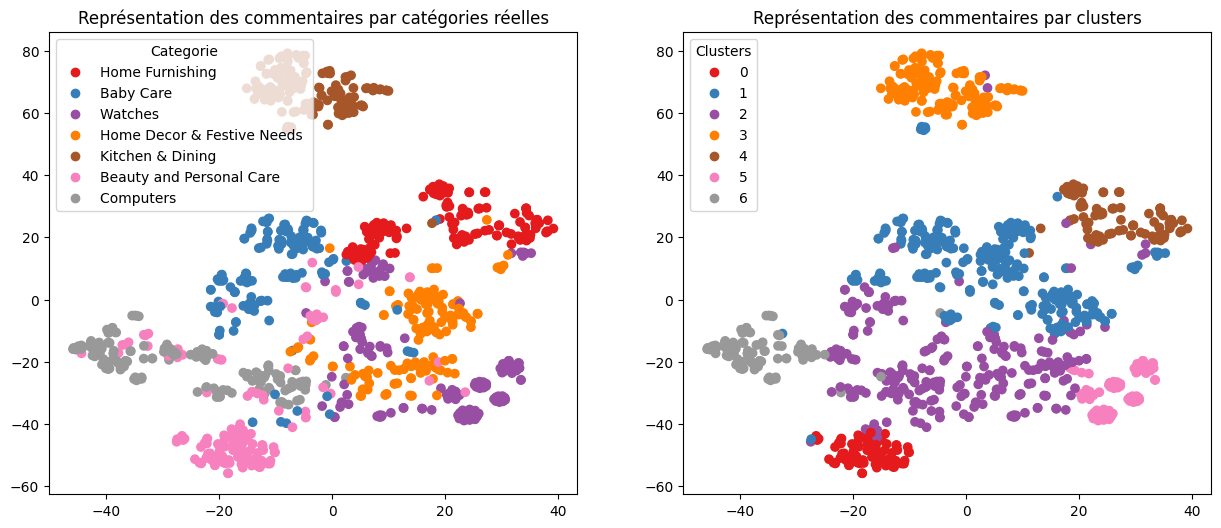

ARI :  0.3503


In [122]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)